In [ ]:
# Домашнее задание №2 (Task_4): Семантическая сегментация облаков точек с RandLA-Net
# Выполнила: Большова Елизавета Александровна

In [32]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import open3d as o3d
import open3d.ml.torch as ml3d
from tqdm import tqdm

# Настройки для стабильности на macOS, пришлось помучиться на CPU
os.environ['OPEN3D_CPU_RENDERING'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

print(f"PyTorch version: {torch.__version__}")
print(f"Open3D version: {o3d.__version__}")

# Путь к данным
dataset_root = "data" 

PyTorch version: 1.13.1
Open3D version: 0.18.0


In [33]:
dataset = ml3d.datasets.SemanticKITTI(
    dataset_path=dataset_root,
    name="poss",
    all_split=["00", "01", "02", "03", "04", "05"],
    training_split=["00", "01", "02", "03"],
    validation_split=["04"],
    test_split=["05"]
)

names = dataset.get_label_to_names()
print("Словарь классов в датасете:")
print(names)

train_split = dataset.get_split('training')

Словарь классов в датасете:
{0: 'unlabeled', 1: 'car', 2: 'bicycle', 3: 'motorcycle', 4: 'truck', 5: 'other-vehicle', 6: 'person', 7: 'bicyclist', 8: 'motorcyclist', 9: 'road', 10: 'parking', 11: 'sidewalk', 12: 'other-ground', 13: 'building', 14: 'fence', 15: 'vegetation', 16: 'trunk', 17: 'terrain', 18: 'pole', 19: 'traffic-sign'}


In [34]:
print("Проверка предобученной модели")

# Путь к весам
ckpt_path = "models/randlanet_semantickitti_202201071330utc.pth"

# Сопоставления классов POSS - KITTI
poss_to_kitti_map = {
    7: 1,   # Car - Car
    15: 13, # Building - Building
    9: 15,  # Vegetation - Vegetation
    22: 9,  # Ground - Road
    4: 6,   # Person - Person
    13: 18  # Pole - Pole
}

def remap_labels(labels, mapping):
    new_labels = np.zeros_like(labels)
    for src, dst in mapping.items():
        new_labels[labels == src] = dst
    return new_labels

# Инициализация модели (19 классов, 3 канала)
model_pretrained = ml3d.models.RandLANet(num_classes=19, in_channels=3)
model_pretrained.device = torch.device('cpu')
model_pretrained.cfg.in_channels = 3

# Загрузка весов
try:
    checkpoint = torch.load(ckpt_path, map_location='cpu')
    state_dict = checkpoint.get('model_state_dict', checkpoint)
    model_pretrained.load_state_dict(state_dict)
    model_pretrained.eval()
    print(f"Веса успешно загружены из {ckpt_path}")
except FileNotFoundError:
    print(f"Ошибка: Файл не найден")

# Пример
raw_data = train_split.get_data(0)
raw_data['label'] = remap_labels(raw_data['label'].astype(np.int32), poss_to_kitti_map)
raw_data['feat'] = None 

data_pre = model_pretrained.preprocess(raw_data, {'split': 'training'})
data_in = model_pretrained.transform(data_pre, {'split': 'training'})

# Конвертация в тензоры
for k in data_in.keys():
    if isinstance(data_in[k], np.ndarray):
        data_in[k] = torch.from_numpy(data_in[k]).unsqueeze(0)
    elif isinstance(data_in[k], list):
        data_in[k] = [torch.from_numpy(val).unsqueeze(0) if isinstance(val, np.ndarray) else val for val in data_in[k]]

with torch.no_grad():
    output = model_pretrained(data_in)

print(f"Размерность выходного тензора: {output.shape}")

Проверка предобученной модели
Веса успешно загружены из models/randlanet_semantickitti_202201071330utc.pth
Размерность выходного тензора: torch.Size([1, 45056, 19])


In [35]:
print("Обучение модели (4 канала)")

# Инициализация новой модели (23 класса для покрытия всех ID в POSS, 4 канала)
model_poss = ml3d.models.RandLANet(num_classes=23, in_channels=4)
model_poss.device = torch.device('cpu')
model_poss.cfg.in_channels = 4
model_poss.train()

optimizer = optim.Adam(model_poss.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

# Цикл обучения (случайный выбор кадров)
import random
train_indices = list(range(len(train_split)))

for i in tqdm(range(200), desc="Training"):
    idx = random.choice(train_indices)
    raw_data = train_split.get_data(idx)
    
    # 4 канала: XYZ + добавляем фиктивный канал интенсивности
    points = raw_data['point'][:, :3].astype(np.float32)
    features = np.ones((points.shape[0], 1), dtype=np.float32)
    d = {'point': points, 'feat': features, 'label': raw_data['label'].astype(np.int32)}
    
    data_pre = model_poss.preprocess(d, {'split': 'training'})
    data_in = model_poss.transform(data_pre, {'split': 'training'})
    
    # Конвертация в тензоры
    for k in data_in.keys():
        if isinstance(data_in[k], np.ndarray):
            data_in[k] = torch.from_numpy(data_in[k]).unsqueeze(0)
        elif isinstance(data_in[k], list):
            data_in[k] = [torch.from_numpy(v).unsqueeze(0) for v in data_in[k]]
    
    optimizer.zero_grad()
    out = model_poss(data_in)
    loss = criterion(out.view(-1, 23), data_in['labels'].view(-1).long())
    loss.backward()
    optimizer.step()

print("Обучение завершено")

Обучение модели (4 канала)


Training: 100%|███████████████████████████████| 200/200 [03:45<00:00,  1.13s/it]

Обучение завершено


In [36]:
print("Тестирование")
model_poss.eval()
correct, total = 0, 0
val_split = dataset.get_split('validation')

with torch.no_grad():
    for i in range(50):
        raw_data = val_split.get_data(i)
        p = raw_data['point'][:, :3].astype(np.float32)
        f = np.ones((p.shape[0], 1), dtype=np.float32)
        d = {'point': p, 'feat': f, 'label': raw_data['label'].astype(np.int32)}
        
        data_pre = model_poss.preprocess(d, {'split': 'validation'})
        data_in = model_poss.transform(data_pre, {'split': 'validation'})
        
        for k in data_in.keys():
            if isinstance(data_in[k], np.ndarray):
                data_in[k] = torch.from_numpy(data_in[k]).unsqueeze(0)
            elif isinstance(data_in[k], list):
                data_in[k] = [torch.from_numpy(v).unsqueeze(0) for v in data_in[k]]
        
        out = model_poss(data_in)
        preds = torch.argmax(out, dim=-1)
        correct += (preds == data_in['labels']).sum().item()
        total += data_in['labels'].numel()

print(f"\nOverall Testing Accuracy: {correct / total:.4f}")

Тестирование

Overall Testing Accuracy: 0.8026


Визуализация сегментации


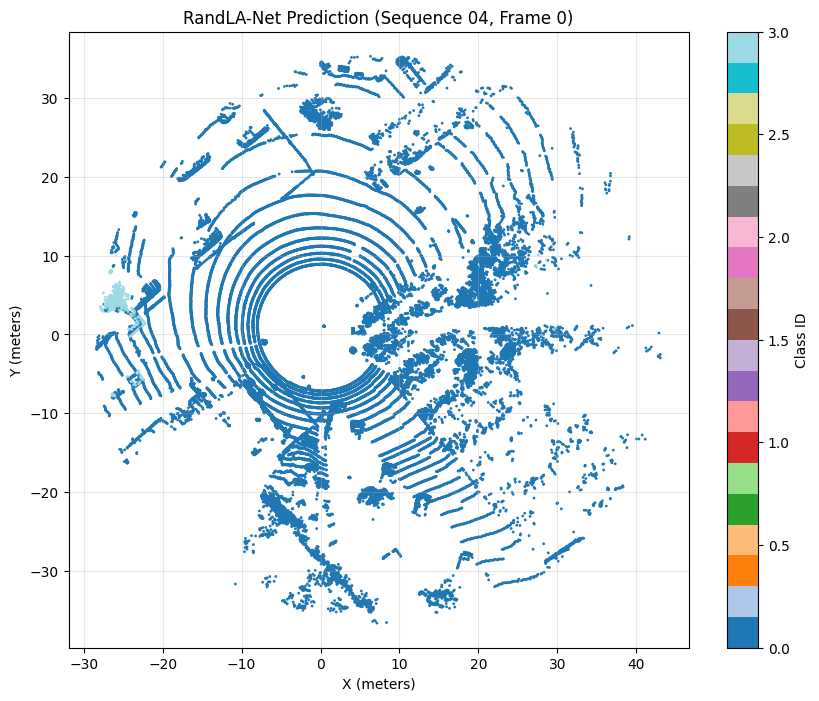

In [39]:
import matplotlib.pyplot as plt

print("Визуализация сегментации")

def plot_bev(points, labels, title):
    # Перевод в numpy
    if isinstance(points, torch.Tensor): points = points.cpu().numpy()
    if isinstance(labels, torch.Tensor): labels = labels.cpu().numpy()
    if len(points.shape) == 3: points = points[0]
    if len(labels.shape) == 2: labels = labels[0]
    
    # Берем только первые 3 колонки
    points = points[:, :3]

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, s=1, cmap='tab20')
    
    plt.colorbar(scatter, label='Class ID')
    plt.title(title)
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()
    
model_poss.eval()
raw_sample = val_split.get_data(0)

# Подготовка 
p_raw = raw_sample['point']
if p_raw.shape[1] == 3:
    p, f = p_raw, np.ones((p_raw.shape[0], 1), dtype=np.float32)
else:
    p, f = p_raw[:, :3], p_raw[:, 3:4]
    
d = {'point': p.astype(np.float32), 'feat': f.astype(np.float32), 'label': raw_sample['label'].astype(np.int32)}

# Прогон через препроцессинг модели
data_pre = model_poss.preprocess(d, {'split': 'validation'})
data_in = model_poss.transform(data_pre, {'split': 'validation'})

# Конвертация в тензоры
for k in data_in.keys():
    if isinstance(data_in[k], np.ndarray):
        data_in[k] = torch.from_numpy(data_in[k]).unsqueeze(0)
    elif isinstance(data_in[k], list):
        data_in[k] = [torch.from_numpy(v).unsqueeze(0) if isinstance(v, np.ndarray) else v for v in data_in[k]]

with torch.no_grad():
    out = model_poss(data_in)
    preds = torch.argmax(out, dim=-1)

if 'coords' in data_in:
    plot_bev(data_in['coords'][0], preds, "RandLA-Net Prediction (Sequence 04, Frame 0)")
else:
    plot_bev(p, preds, "RandLA-Net Prediction (Original Scale)")